In [ ]:
# train a generative adversarial network on a one-dimensional function
import pandas as pd
from numpy import hstack
import numpy as np
from datetime import datetime
from numpy import zeros
from numpy import ones
import random
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Conv1D, LeakyReLU, Reshape, UpSampling1D
from keras.optimizers import Adam
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from tqdm import tqdm
from tensorflow import keras
from keras.models import save_model, load_model
from statistics import mean, variance, pstdev
from sklearn.preprocessing import MinMaxScaler
from statistics import mean, variance, pstdev
from scipy.spatial import distance
from scipy.stats import wilcoxon
from collections import defaultdict
from PIL import Image
import seaborn as sns
from sklearn import svm, metrics

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LENGTH_INPUT = 288
latent_dim = 500

# Prepare training data

In [ ]:
df_570 =  pd.read_csv('/content/drive/MyDrive/Thesis/processed data/570.csv')

In [ ]:
df_570['time'] = pd.to_datetime(df_570['time'], dayfirst=True)

In [ ]:
df_570['date'] = df_570['time'].apply(lambda x: x.date())
dates = df_570['date'].unique()
meal_570 = []
for date in dates:
    meal_570.append(df_570[df_570['date'] == date]['meal_value'].values)

In [ ]:
scaler = MinMaxScaler().fit(meal_570)
meal_570 = scaler.transform(meal_570)

In [ ]:
meal_570 = np.array(meal_570)
y = ones((50, 1))

In [ ]:
meal_570.shape

(50, 288)

# Model Architecture

In [ ]:
# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    
    # Dense layer
    model.add(Dense(1, input_shape=(288,1)))
    model.add(LeakyReLU())
    
    # Convolutional layer with LeakyReLU activation
    model.add(Conv1D(32, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU())

    # Convolutional layer with LeakyReLU activation
    model.add(Conv1D(32, kernel_size=2, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    # Reshape layer
    model.add(Reshape((2304,)))
    
    # Dense layer
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.0001)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# define the standalone generator model
def define_generator():
    model = Sequential()
    
    # Dense layer
    model.add(Dense(3600, input_shape=(latent_dim,)))
    model.add(LeakyReLU())
    
    # Reshape layer
    model.add(Reshape((72, 50)))
    
    # Upsampling layer
    model.add(UpSampling1D(size=4))
    
    # Convolutional layer
    model.add(Conv1D(filters=32, kernel_size=2, strides=2, padding='same'))
    
    # Upsampling layer
    model.add(UpSampling1D(size=4))
    
    # Convolutional layer + leaky relu layer
    model.add(Conv1D(filters=32, kernel_size=2, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    # Convolutional layer
    model.add(Conv1D(filters=1, kernel_size=1, padding='same'))
    
    model.compile(optimizer='adam')

    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(n):
    # generate points in the latent space from the normal distribution
    x_input = np.random.normal(size = latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)

    return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
    # generate points in latent space
    x_input = generate_latent_points(n)
    # predict outputs
    X = generator.predict(x_input, verbose=0)
    # create class labels
    y = zeros((n, 1))

    return X, y

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=50, n_eval=100):
    d_loss_list = []
    g_loss_list = []
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)+1
    
    # manually enumerate epochs
    for i in tqdm(range(n_epochs)):
        
        # prepare real samples
        rand_index = random.sample(range(0,50), 26)
        x_real, y_real = meal_570[rand_index], y[rand_index]
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, half_batch)
        
        # update discriminator
        d_loss_real = d_model.train_on_batch(x_real, y_real)
        d_loss_fake = d_model.train_on_batch(x_fake, y_fake)
        # average of d_loss_real and d_loss_fake
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_loss_list.append(d_loss)
        #print(d_loss[0])

        # prepare points in latent space as input for the generator
        #for _ in range(4):
        x_gan = generate_latent_points(n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(x_gan, y_gan)
        g_loss_list.append(g_loss)
        
       
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            generator.save_weights('/content/drive/MyDrive/Thesis/model/normal_gan/570_meal_0.0005/generator_weights_%d.h5' %(i+1))
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss))

In [ ]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288, 1)            2         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 288, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 144, 32)           160       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 32)            2080      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 72, 32)            0         
                                                                 
 reshape (Reshape)           (None, 2304)              0

In [ ]:
generator = define_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3600)              1803600   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 3600)              0         
                                                                 
 reshape_1 (Reshape)         (None, 72, 50)            0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 288, 50)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 144, 32)           3232      
                                                                 
 up_sampling1d_1 (UpSampling  (None, 576, 32)          0         
 1D)                                                  

In [ ]:
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

  1%|          | 101/10000 [00:18<1:08:35,  2.41it/s]

99 [D loss: 0.628593, acc.: 100.00%] [G loss: 0.808300]


  2%|▏         | 201/10000 [00:30<21:12,  7.70it/s]

199 [D loss: 0.615685, acc.: 100.00%] [G loss: 0.775172]


  3%|▎         | 301/10000 [00:43<21:19,  7.58it/s]

299 [D loss: 0.599419, acc.: 100.00%] [G loss: 0.777987]


  4%|▍         | 401/10000 [00:56<21:46,  7.35it/s]

399 [D loss: 0.600086, acc.: 100.00%] [G loss: 0.763706]


  5%|▌         | 501/10000 [01:09<20:53,  7.58it/s]

499 [D loss: 0.627472, acc.: 90.38%] [G loss: 0.720074]


  6%|▌         | 601/10000 [01:21<20:50,  7.52it/s]

599 [D loss: 0.654376, acc.: 69.23%] [G loss: 0.683612]


  7%|▋         | 701/10000 [01:34<20:57,  7.39it/s]

699 [D loss: 0.670092, acc.: 51.92%] [G loss: 0.672526]


  8%|▊         | 801/10000 [01:47<20:24,  7.51it/s]

799 [D loss: 0.678972, acc.: 50.00%] [G loss: 0.674458]


  9%|▉         | 901/10000 [02:01<23:01,  6.59it/s]

899 [D loss: 0.664967, acc.: 78.85%] [G loss: 0.699283]


 10%|█         | 1001/10000 [02:14<20:38,  7.27it/s]

999 [D loss: 0.650688, acc.: 96.15%] [G loss: 0.731206]


 11%|█         | 1101/10000 [02:27<19:58,  7.43it/s]

1099 [D loss: 0.636151, acc.: 96.15%] [G loss: 0.707483]


 12%|█▏        | 1201/10000 [02:40<19:27,  7.54it/s]

1199 [D loss: 0.624824, acc.: 96.15%] [G loss: 0.721224]


 13%|█▎        | 1301/10000 [02:53<20:08,  7.20it/s]

1299 [D loss: 0.633642, acc.: 80.77%] [G loss: 0.706841]


 14%|█▍        | 1401/10000 [03:05<19:16,  7.43it/s]

1399 [D loss: 0.665483, acc.: 57.69%] [G loss: 0.658648]


 15%|█▌        | 1501/10000 [03:18<19:03,  7.43it/s]

1499 [D loss: 0.682830, acc.: 55.77%] [G loss: 0.696441]


 16%|█▌        | 1601/10000 [03:31<18:16,  7.66it/s]

1599 [D loss: 0.614848, acc.: 88.46%] [G loss: 0.824353]


 17%|█▋        | 1701/10000 [03:44<18:39,  7.41it/s]

1699 [D loss: 0.573679, acc.: 100.00%] [G loss: 0.847694]


 18%|█▊        | 1801/10000 [03:56<18:17,  7.47it/s]

1799 [D loss: 0.593870, acc.: 100.00%] [G loss: 0.797420]


 19%|█▉        | 1901/10000 [04:10<19:48,  6.81it/s]

1899 [D loss: 0.611390, acc.: 100.00%] [G loss: 0.768693]


 20%|██        | 2001/10000 [04:24<17:27,  7.63it/s]

1999 [D loss: 0.580736, acc.: 100.00%] [G loss: 0.815844]


 21%|██        | 2101/10000 [04:36<17:34,  7.49it/s]

2099 [D loss: 0.577946, acc.: 100.00%] [G loss: 0.803974]


 22%|██▏       | 2201/10000 [04:49<17:25,  7.46it/s]

2199 [D loss: 0.542668, acc.: 100.00%] [G loss: 0.816051]


 23%|██▎       | 2301/10000 [05:01<16:52,  7.60it/s]

2299 [D loss: 0.513056, acc.: 100.00%] [G loss: 0.858807]


 24%|██▍       | 2401/10000 [05:14<17:56,  7.06it/s]

2399 [D loss: 0.466207, acc.: 100.00%] [G loss: 0.923941]


 25%|██▌       | 2501/10000 [05:27<16:35,  7.53it/s]

2499 [D loss: 0.461140, acc.: 100.00%] [G loss: 0.926739]


 26%|██▌       | 2601/10000 [05:40<16:23,  7.52it/s]

2599 [D loss: 0.447696, acc.: 96.15%] [G loss: 1.241085]


 27%|██▋       | 2701/10000 [05:52<16:32,  7.35it/s]

2699 [D loss: 0.298036, acc.: 100.00%] [G loss: 1.406176]


 28%|██▊       | 2801/10000 [06:05<16:51,  7.12it/s]

2799 [D loss: 0.416705, acc.: 100.00%] [G loss: 1.049250]


 29%|██▉       | 2901/10000 [06:18<17:59,  6.58it/s]

2899 [D loss: 0.391925, acc.: 100.00%] [G loss: 1.188126]


 30%|███       | 3001/10000 [06:32<15:46,  7.39it/s]

2999 [D loss: 0.330064, acc.: 100.00%] [G loss: 1.300411]


 31%|███       | 3101/10000 [06:45<15:23,  7.47it/s]

3099 [D loss: 0.368033, acc.: 100.00%] [G loss: 1.057441]


 32%|███▏      | 3201/10000 [06:57<14:54,  7.60it/s]

3199 [D loss: 0.324062, acc.: 100.00%] [G loss: 1.245587]


 33%|███▎      | 3301/10000 [07:10<14:40,  7.61it/s]

3299 [D loss: 0.278563, acc.: 100.00%] [G loss: 1.391512]


 34%|███▍      | 3401/10000 [07:22<14:20,  7.67it/s]

3399 [D loss: 0.236281, acc.: 100.00%] [G loss: 1.462544]


 35%|███▌      | 3501/10000 [07:34<14:15,  7.60it/s]

3499 [D loss: 0.265101, acc.: 100.00%] [G loss: 2.307950]


 36%|███▌      | 3601/10000 [07:47<14:02,  7.60it/s]

3599 [D loss: 0.091871, acc.: 100.00%] [G loss: 2.912730]


 37%|███▋      | 3701/10000 [07:59<13:30,  7.77it/s]

3699 [D loss: 0.160633, acc.: 100.00%] [G loss: 2.003172]


 38%|███▊      | 3801/10000 [08:11<13:27,  7.68it/s]

3799 [D loss: 0.336354, acc.: 100.00%] [G loss: 1.229458]


 39%|███▉      | 3901/10000 [08:25<15:08,  6.71it/s]

3899 [D loss: 0.281102, acc.: 100.00%] [G loss: 1.242182]


 40%|████      | 4001/10000 [08:39<13:29,  7.41it/s]

3999 [D loss: 0.224887, acc.: 100.00%] [G loss: 1.463262]


 41%|████      | 4101/10000 [08:51<12:53,  7.63it/s]

4099 [D loss: 0.224153, acc.: 100.00%] [G loss: 1.470273]


 42%|████▏     | 4201/10000 [09:04<12:24,  7.79it/s]

4199 [D loss: 0.162294, acc.: 100.00%] [G loss: 1.763471]


 43%|████▎     | 4301/10000 [09:16<11:55,  7.96it/s]

4299 [D loss: 0.121046, acc.: 100.00%] [G loss: 2.110112]


 44%|████▍     | 4401/10000 [09:28<11:58,  7.80it/s]

4399 [D loss: 0.117534, acc.: 100.00%] [G loss: 2.170133]


 45%|████▌     | 4501/10000 [09:41<11:50,  7.74it/s]

4499 [D loss: 0.100743, acc.: 100.00%] [G loss: 2.198636]


 46%|████▌     | 4601/10000 [09:53<12:02,  7.47it/s]

4599 [D loss: 0.103224, acc.: 100.00%] [G loss: 2.284374]


 47%|████▋     | 4701/10000 [10:05<11:35,  7.62it/s]

4699 [D loss: 0.232751, acc.: 94.23%] [G loss: 1.812404]


 48%|████▊     | 4801/10000 [10:18<11:31,  7.52it/s]

4799 [D loss: 0.121139, acc.: 100.00%] [G loss: 3.270549]


 49%|████▉     | 4901/10000 [10:31<16:19,  5.21it/s]

4899 [D loss: 0.059488, acc.: 100.00%] [G loss: 3.505999]


 50%|█████     | 5001/10000 [10:44<11:51,  7.03it/s]

4999 [D loss: 0.064676, acc.: 100.00%] [G loss: 3.055075]


 51%|█████     | 5101/10000 [10:57<10:34,  7.72it/s]

5099 [D loss: 0.113831, acc.: 100.00%] [G loss: 2.202447]


 52%|█████▏    | 5201/10000 [11:10<10:39,  7.50it/s]

5199 [D loss: 0.121180, acc.: 100.00%] [G loss: 2.174086]


 53%|█████▎    | 5301/10000 [11:22<10:13,  7.65it/s]

5299 [D loss: 0.055868, acc.: 100.00%] [G loss: 3.573996]


 54%|█████▍    | 5401/10000 [11:34<10:10,  7.54it/s]

5399 [D loss: 0.077817, acc.: 100.00%] [G loss: 2.389524]


 55%|█████▌    | 5501/10000 [11:47<09:52,  7.60it/s]

5499 [D loss: 0.073380, acc.: 100.00%] [G loss: 2.550284]


 56%|█████▌    | 5601/10000 [11:59<09:32,  7.69it/s]

5599 [D loss: 0.049756, acc.: 100.00%] [G loss: 2.954241]


 57%|█████▋    | 5701/10000 [12:11<09:17,  7.72it/s]

5699 [D loss: 0.032907, acc.: 100.00%] [G loss: 3.986768]


 58%|█████▊    | 5801/10000 [12:24<09:12,  7.60it/s]

5799 [D loss: 0.035048, acc.: 100.00%] [G loss: 3.572096]


 59%|█████▉    | 5901/10000 [12:38<09:45,  7.00it/s]

5899 [D loss: 0.028561, acc.: 100.00%] [G loss: 3.443900]


 60%|██████    | 6001/10000 [12:50<08:28,  7.86it/s]

5999 [D loss: 0.031027, acc.: 100.00%] [G loss: 3.423836]


 61%|██████    | 6101/10000 [13:03<08:35,  7.57it/s]

6099 [D loss: 0.028155, acc.: 100.00%] [G loss: 3.487739]


 62%|██████▏   | 6201/10000 [13:15<08:24,  7.53it/s]

6199 [D loss: 0.023350, acc.: 100.00%] [G loss: 3.644950]


 63%|██████▎   | 6301/10000 [13:28<08:11,  7.53it/s]

6299 [D loss: 0.022241, acc.: 100.00%] [G loss: 4.100610]


 64%|██████▍   | 6401/10000 [13:40<07:58,  7.51it/s]

6399 [D loss: 0.030116, acc.: 100.00%] [G loss: 3.723094]


 65%|██████▌   | 6501/10000 [13:53<07:46,  7.51it/s]

6499 [D loss: 0.060224, acc.: 100.00%] [G loss: 3.487942]


 66%|██████▌   | 6601/10000 [14:05<07:24,  7.65it/s]

6599 [D loss: 0.019885, acc.: 100.00%] [G loss: 4.954903]


 67%|██████▋   | 6701/10000 [14:18<07:09,  7.69it/s]

6699 [D loss: 0.012032, acc.: 100.00%] [G loss: 5.200112]


 68%|██████▊   | 6801/10000 [14:30<07:02,  7.57it/s]

6799 [D loss: 0.016317, acc.: 100.00%] [G loss: 4.342483]


 69%|██████▉   | 6901/10000 [14:43<07:34,  6.82it/s]

6899 [D loss: 0.016317, acc.: 100.00%] [G loss: 4.422587]


 70%|███████   | 7001/10000 [14:57<07:21,  6.80it/s]

6999 [D loss: 0.022847, acc.: 100.00%] [G loss: 3.770316]


 71%|███████   | 7101/10000 [15:10<06:33,  7.37it/s]

7099 [D loss: 0.023614, acc.: 100.00%] [G loss: 3.616481]


 72%|███████▏  | 7201/10000 [15:22<06:01,  7.74it/s]

7199 [D loss: 0.010844, acc.: 100.00%] [G loss: 4.571826]


 73%|███████▎  | 7301/10000 [15:34<05:57,  7.54it/s]

7299 [D loss: 0.010327, acc.: 100.00%] [G loss: 4.783175]


 74%|███████▍  | 7401/10000 [15:47<05:40,  7.62it/s]

7399 [D loss: 0.008668, acc.: 100.00%] [G loss: 4.789310]


 75%|███████▌  | 7501/10000 [15:59<05:20,  7.79it/s]

7499 [D loss: 0.009622, acc.: 100.00%] [G loss: 4.385633]


 76%|███████▌  | 7601/10000 [16:11<05:10,  7.72it/s]

7599 [D loss: 0.006329, acc.: 100.00%] [G loss: 4.888012]


 77%|███████▋  | 7701/10000 [16:24<04:55,  7.78it/s]

7699 [D loss: 0.006960, acc.: 100.00%] [G loss: 4.963491]


 78%|███████▊  | 7801/10000 [16:36<04:53,  7.50it/s]

7799 [D loss: 0.005920, acc.: 100.00%] [G loss: 5.205278]


 79%|███████▉  | 7901/10000 [16:49<05:09,  6.79it/s]

7899 [D loss: 0.004645, acc.: 100.00%] [G loss: 5.417858]


 80%|████████  | 8001/10000 [17:03<04:40,  7.12it/s]

7999 [D loss: 0.004726, acc.: 100.00%] [G loss: 5.276373]


 81%|████████  | 8101/10000 [17:15<04:08,  7.64it/s]

8099 [D loss: 0.003677, acc.: 100.00%] [G loss: 5.592859]


 82%|████████▏ | 8201/10000 [17:28<03:49,  7.84it/s]

8199 [D loss: 0.003909, acc.: 100.00%] [G loss: 5.541175]


 83%|████████▎ | 8301/10000 [17:40<03:37,  7.83it/s]

8299 [D loss: 0.003100, acc.: 100.00%] [G loss: 5.842490]


 84%|████████▍ | 8401/10000 [17:52<03:29,  7.62it/s]

8399 [D loss: 0.003227, acc.: 100.00%] [G loss: 5.921907]


 85%|████████▌ | 8501/10000 [18:05<03:12,  7.78it/s]

8499 [D loss: 0.002606, acc.: 100.00%] [G loss: 5.944802]


 86%|████████▌ | 8601/10000 [18:17<03:03,  7.64it/s]

8599 [D loss: 0.002388, acc.: 100.00%] [G loss: 6.270882]


 87%|████████▋ | 8701/10000 [18:29<02:54,  7.44it/s]

8699 [D loss: 0.002671, acc.: 100.00%] [G loss: 7.334111]


 88%|████████▊ | 8801/10000 [18:42<02:40,  7.46it/s]

8799 [D loss: 0.002118, acc.: 100.00%] [G loss: 6.384411]


 89%|████████▉ | 8901/10000 [18:54<02:27,  7.48it/s]

8899 [D loss: 0.002397, acc.: 100.00%] [G loss: 6.835252]


 90%|█████████ | 9001/10000 [19:08<02:25,  6.85it/s]

8999 [D loss: 0.001715, acc.: 100.00%] [G loss: 6.999449]


 91%|█████████ | 9101/10000 [19:21<01:58,  7.57it/s]

9099 [D loss: 0.001710, acc.: 100.00%] [G loss: 6.720170]


 92%|█████████▏| 9201/10000 [19:34<01:48,  7.39it/s]

9199 [D loss: 0.000889, acc.: 100.00%] [G loss: 7.229709]


 93%|█████████▎| 9301/10000 [19:46<01:36,  7.23it/s]

9299 [D loss: 0.000907, acc.: 100.00%] [G loss: 7.281358]


 94%|█████████▍| 9401/10000 [19:59<01:23,  7.20it/s]

9399 [D loss: 0.000745, acc.: 100.00%] [G loss: 7.572174]


 95%|█████████▌| 9501/10000 [20:11<01:08,  7.29it/s]

9499 [D loss: 0.001019, acc.: 100.00%] [G loss: 6.937610]


 96%|█████████▌| 9601/10000 [20:24<00:57,  6.92it/s]

9599 [D loss: 0.000745, acc.: 100.00%] [G loss: 7.253346]


 97%|█████████▋| 9701/10000 [20:36<00:40,  7.37it/s]

9699 [D loss: 0.000731, acc.: 100.00%] [G loss: 7.246692]


 98%|█████████▊| 9801/10000 [20:48<00:26,  7.43it/s]

9799 [D loss: 0.000512, acc.: 100.00%] [G loss: 7.421022]


 99%|█████████▉| 9901/10000 [21:01<00:13,  7.58it/s]

9899 [D loss: 0.000565, acc.: 100.00%] [G loss: 7.370222]


100%|██████████| 10000/10000 [21:15<00:00,  7.84it/s]

9999 [D loss: 0.000505, acc.: 100.00%] [G loss: 7.660263]


# Evaluation

In [ ]:
synth_norm_list = []
for i in tqdm(range(1, 101)):
  generator.load_weights('/content/drive/MyDrive/Thesis/model/normal_gan/570_meal_0.0005/generator_weights_' + str(i*100) + '.h5')

  synth, _ = generate_fake_samples(generator, 50)
  synth = synth.reshape(50,288)

  synth_norm_list.append(synth)

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


In [ ]:
# save normalized synthetic data
np.save("/content/drive/MyDrive/Thesis/best model/normgan_meal/570_normalized.npy",synth_norm_list)

In [ ]:
for i in range(len(synth_norm_list)):
  synth_norm_list[i] = scaler.inverse_transform(synth_norm_list[i])

In [ ]:
# save unnormalized synthetic data
np.save("/content/drive/MyDrive/Thesis/best model/normgan_meal/570_unnormalized.npy",synth_norm_list)

Visualizations of normal GAN and TimeGAN

In [ ]:
synth_normgan_nonnorm = np.load("/content/drive/MyDrive/Thesis/best model/normgan_meal/570_unnormalized.npy")
synth_normgan_norm = np.load("/content/drive/MyDrive/Thesis/best model/normgan_meal/570_normalized.npy")
synth_timegan_nonnorm = np.load("/content/drive/MyDrive/Thesis/best model/timegan_570_128/synthetic_data_nonorm.npy")
synth_timegan_norm = np.load("/content/drive/MyDrive/Thesis/best model/timegan_570_128/synthetic_data.npy")
real_ori = scaler.inverse_transform(meal_570)

In [ ]:
def seqAverage(ts, n, feature_window_size):

    sub_ts_list = []

    for i in range(0, n - n % feature_window_size, feature_window_size):
        sub_ts = ts[i: i + feature_window_size]
        sub_ts_list.append(sub_ts.mean())
    
    return pd.DataFrame(sub_ts_list)

In [ ]:
# discretize y values
def discretize(ts, bins=None, global_min=None, global_max=None):
    ts = seqAverage(ts, 288, 6)

    if np.isscalar(bins):
        num_bins = bins

        min_value = ts.min()[0]
        #print(min_value)
        max_value = ts.max()[0]
        #print(max_value)
        if min_value == max_value:
            min_value = global_min
            max_value = global_max
        step = (max_value - min_value) / num_bins
        ts_bins = np.arange(min_value, max_value, step)
    else:
        ts_bins = bins

    inds = np.digitize(ts, ts_bins)
    binned_ts = tuple(str(i - 1) for i in inds)
    return binned_ts

In [ ]:
def get_bitmap(chunk, level_size=2):
    """

    :param str chunk: symbol sequence representation of a univariate time series
    :param int level_size: desired level of recursion of the bitmap
    :return : bitmap representation of `chunk`
    """
    bitmap = defaultdict(int)
    n = len(chunk)

    for i in range(n):
        if i <= n - level_size:
            feat = chunk[i: i + level_size]
            bitmap[feat] += 1  # frequency count
    max_freq = max(bitmap.values())
    for feat in bitmap.keys():
        #print(bitmap[feat])
        #print(max_freq)
        bitmap[feat] = bitmap[feat] / max_freq
    return bitmap

In [ ]:
def imageList(bitmap):
  final_list = [[0 for i in range(4)] for j in range(4)]
  for key, value in bitmap.items():
      num1 = int(key[0][1])
      num2 = int(key[1][1])
      
      if num1 == 0:
          if num2 == 0:
              final_list[0][0] = value
          elif num2 == 1:
              final_list[0][1] = value
          elif num2 == 2:
              final_list[1][0] = value
          elif num2 == 3:
              final_list[1][1] = value
      elif num1 == 1:
          if num2 == 0:
              final_list[0][2] = value
          elif num2 == 1:
              final_list[0][3] = value
          elif num2 == 2:
              final_list[1][2] = value
          elif num2 == 3:
              final_list[1][3] = value
      elif num1 == 2:
          if num2 == 0:
              final_list[2][0] = value
          elif num2 == 1:
              final_list[2][1] = value
          elif num2 == 2:
              final_list[3][0] = value
          elif num2 == 3:
              final_list[3][1] = value
      elif num1 == 3:
          if num2 == 0:
              final_list[2][2] = value
          elif num2 == 1:
              final_list[2][3] = value
          elif num2 == 2:
              final_list[3][2] = value
          elif num2 == 3:
              final_list[3][3] = value
  
  return final_list

In [ ]:
def showImage(final_list):
  plt.imshow(final_list, cmap='jet', interpolation='nearest')
  plt.colorbar()
  plt.axis('off')
  plt.show()

In [ ]:
# average value of original data from all days
total_ori = []
list_mean_ori = 0
for i in range(50):
  bitmap_ori = get_bitmap(discretize(pd.DataFrame(meal_570[i]), 4))
  total_ori.append(imageList(bitmap_ori))

for i in range(len(total_ori)):
  list_mean_ori = list_mean_ori + np.array(total_ori[i])
  list_mean_ori = list_mean_ori/len(total_ori)

In [ ]:
# average value of TimeGAN synthetic data from all days
total_timegan = []
list_mean_timegan = 0
for i in range(50):
  bitmap_timegan = get_bitmap(discretize(pd.DataFrame(synth_timegan_norm[1][0][i][:,1]), 4))
  total_timegan.append(imageList(bitmap_timegan))

for i in range(len(total_timegan)):
  list_mean_timegan = list_mean_timegan + np.array(total_timegan[i])
  list_mean_timegan = list_mean_timegan/len(total_timegan)

In [ ]:
# average value of normal GAN synthetic data from all days
total_normgan = []
list_mean_normgan = 0
for i in range(50):
  bitmap_normgan = get_bitmap(discretize(pd.DataFrame(synth_normgan_norm[90][i]), 4))
  total_normgan.append(imageList(bitmap_normgan))

for i in range(len(total_normgan)):
  list_mean_normgan = list_mean_normgan + np.array(total_normgan[i])
  list_mean_normgan = list_mean_normgan/len(total_normgan)

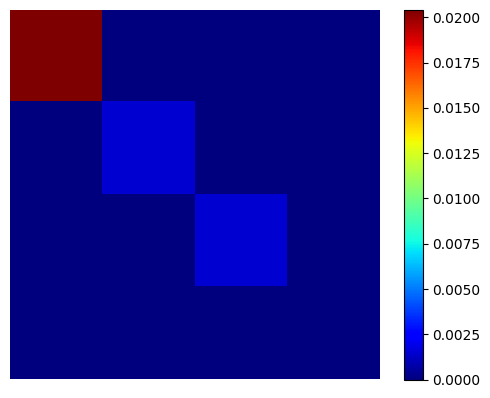

In [ ]:
showImage(list_mean_ori)

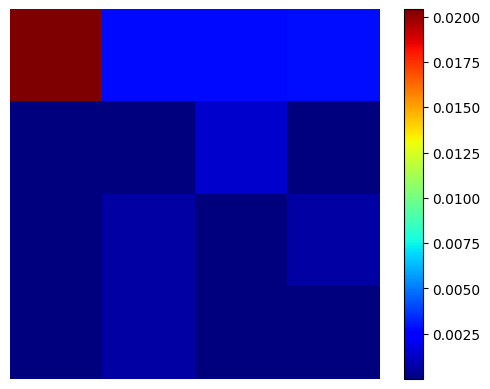

In [ ]:
showImage(list_mean_timegan)

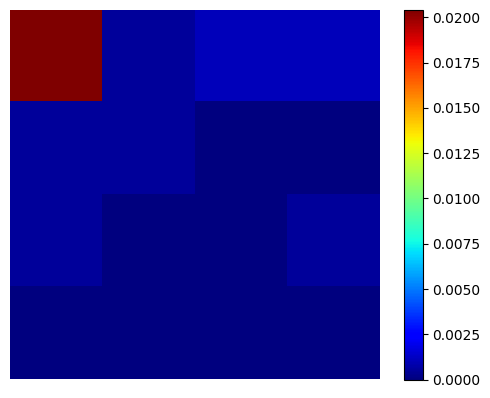

In [ ]:
showImage(list_mean_normgan)

<Axes: title={'center': 'meal event (Patient 570)'}>

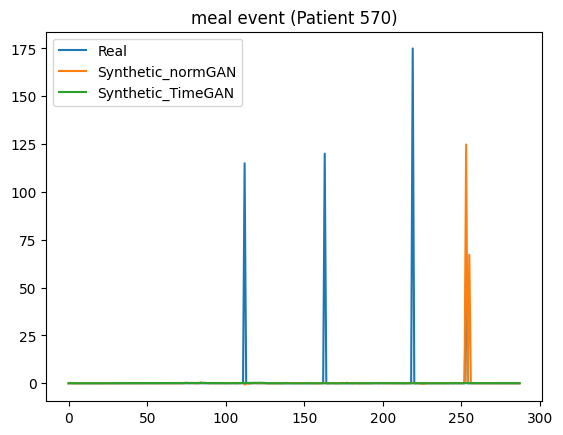

In [ ]:
cols = 'meal event (Patient 570)'

df = pd.DataFrame({'Real': real_ori[11], 'Synthetic_normGAN': synth_normgan_nonnorm[90][11], 'Synthetic_TimeGAN': synth_timegan_nonnorm[1][0][11][:, 1]})
df.plot(title = cols,
        secondary_y='Synthetic data', style=['-'])

SVM

In [ ]:
synth_normgan_nonnorm = np.load("/content/drive/MyDrive/Thesis/best model/normgan_meal/570_unnormalized.npy")
synth_normgan_norm = np.load("/content/drive/MyDrive/Thesis/best model/normgan_meal/570_normalized.npy")
synth_timegan_nonnorm = np.load("/content/drive/MyDrive/Thesis/best model/timegan_570_128/synthetic_data_nonorm.npy")
synth_timegan_norm = np.load("/content/drive/MyDrive/Thesis/best model/timegan_570_128/synthetic_data.npy")

In [ ]:
def getSVM(lamda, times):
  # value < 0.01 -> 0
  for i in range(len(meal_570)):
    for j in range(len(meal_570[0])):
      if abs(synth_timegan_norm[1][0][i][j,1]) < lamda:
        synth_timegan_norm[1][0][i][j,1] = 0
      if abs(synth_normgan_norm[90][i][j]) < lamda:
        synth_normgan_norm[90][i][j] = 0

  x_real_norm = meal_570.tolist()
  y_real_norm = my_list = [1]*50
  x_real_time = meal_570.tolist()
  y_real_time = my_list = [1]*50

  x_timegan = [synth_timegan_norm[1][0][i][:,1].tolist() for i in range(50)]
  y_timegan = [0]*50
  x_normgan = synth_normgan_norm[90]
  y_normgan = [0]*50


  x_real_norm.extend(x_normgan)
  y_real_norm.extend(y_normgan)
  x_real_time.extend(x_timegan)
  y_real_time.extend(y_timegan)

  accuracy_norm = []
  accuracy_time = []
  for i in range(times):
    numbers = list(range(100))
    num_selected_70 = random.sample(numbers, int(0.7*len(numbers)))
    num_selected_30 = list(set(numbers) - set(num_selected_70))

    training_x_norm = [x_real_norm[num_selected_70[i]] for i in range(len(num_selected_70))]
    test_x_norm = [x_real_norm[num_selected_30[i]] for i in range(len(num_selected_30))]
    training_y_norm = [y_real_norm[num_selected_70[i]] for i in range(len(num_selected_70))]
    test_y_norm = [y_real_norm[num_selected_30[i]] for i in range(len(num_selected_30))]


    training_x_time = [x_real_time[num_selected_70[i]] for i in range(len(num_selected_70))]
    test_x_time = [x_real_time[num_selected_30[i]] for i in range(len(num_selected_30))]
    training_y_time = [y_real_time[num_selected_70[i]] for i in range(len(num_selected_70))]
    test_y_time = [y_real_time[num_selected_30[i]] for i in range(len(num_selected_30))]

    
    classifier_norm = svm.SVC()
    classifier_time = svm.SVC()

    # Train the classifier on the training data
    classifier_norm.fit(training_x_norm, training_y_norm)
    classifier_time.fit(training_x_time, training_y_time)

    # Predict the labels of the test data
    y_pred_norm = classifier_norm.predict(test_x_norm)
    y_pred_time = classifier_time.predict(test_x_time)

    # Calculate the accuracy and F1 score of the classifier
    accuracy_norm.append(metrics.accuracy_score(test_y_norm, y_pred_norm))
    accuracy_time.append(metrics.accuracy_score(test_y_time, y_pred_time))

  return accuracy_norm, accuracy_time

In [ ]:
acc_norm_0, acc_time_0 = getSVM(0, 10)
acc_norm_1e2, acc_time_1e2 = getSVM(0.01, 10)
acc_norm_2, acc_time_2 = getSVM(0.02, 10)
acc_norm_5, acc_time_5 = getSVM(0.05, 10)
acc_norm_1, acc_time_1 = getSVM(0.1, 10)

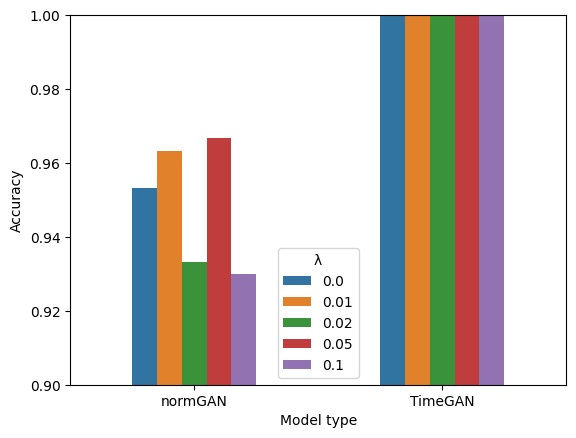

In [ ]:
import seaborn as sns

λ = [0,0.01,0.02,0.05,0.1,0,0.01,0.02,0.05,0.1]
model_type = ['normGAN','normGAN','normGAN','normGAN','normGAN','TimeGAN','TimeGAN','TimeGAN','TimeGAN','TimeGAN']
acc = [mean(acc_norm_0), mean(acc_norm_1e2), mean(acc_norm_2), mean(acc_norm_5), mean(acc_norm_1), mean(acc_time_0), mean(acc_time_1e2), mean(acc_time_2), mean(acc_time_5), mean(acc_time_1)]
df_svm = pd.DataFrame(list(zip(λ, model_type, acc)), columns = ['λ', 'model', 'acc'])

ax = sns.barplot(x="model", y="acc", hue="λ", data=df_svm, width=0.5)

ax.set_ylim([0.9, 1])
ax.set_yticks([0.9, 0.92, 0.94, 0.96, 0.98, 1.0])
ax.set_xlabel("Model type")
ax.set_ylabel("Accuracy")
plt.show()